In [1]:
#standard libraries
import warnings
warnings.filterwarnings('ignore')
import os
import time
import numpy as np
import pandas as pd

from gensim.corpora import Dictionary
from gensim.models import LdaModel

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#reading in relevant data frames
del_df = pd.read_pickle("data/del_df.pkl")
mum_df = pd.read_pickle("data/mum_df.pkl")
ban_df = pd.read_pickle("data/ban_df.pkl")

In [3]:
def topic_coherence(tokens, num_topics, return_coh = True):
    #create a dictionary (a list of all the tokens)
    dictionary = Dictionary(tokens.values)
    dictionary.filter_extremes(no_below=10, no_above=0.9)
    
    # use the dictionary to create a bag of word representation of each document
    corpus = [dictionary.doc2bow(token) for token in tokens.values]
    
    lda_model = LdaModel(corpus = corpus, id2word = dictionary, num_topics = num_topics, random_state = 42)
    topic_words = lda_model.top_topics(corpus, coherence = 'c_v', texts = tokens.values, topn = 20) #top 20 words

    if return_coh:
        avg_coherence = 0
        for i in range(0, num_topics):
            avg_coherence += topic_words[i][-1]
        avg_coherence = round(avg_coherence/num_topics,2)
        return topic_words, avg_coherence

    else: 
        return topic_words

In [4]:
def optimal_topics(df):
    """this function helps determine the optimal number of topics for a given dataset based on the coherence score"""
    
    num_of_topics = range(1, 11, 1) #considering between 1 and 10 topics
    avg_coherence = []
    for i in num_of_topics:
        avg_coherence.append(topic_coherence(df["processed_text"], i)[-1])
                         
    return avg_coherence

top_coh = pd.DataFrame(index = range(1,11,1))
top_coh["del"] = optimal_topics(del_df)
top_coh["mum"] = optimal_topics(mum_df)
top_coh["ban"] = optimal_topics(ban_df)
top_coh

,del,mum,ban
1,0.66,0.79,0.76
2,0.84,0.81,0.75
3,0.66,0.84,0.69
4,0.65,0.76,0.70
5,0.64,0.77,0.66
6,0.67,0.70,0.63
7,0.62,0.66,0.64
8,0.57,0.64,0.64
9,0.63,0.60,0.64
10,0.60,0.60,0.62


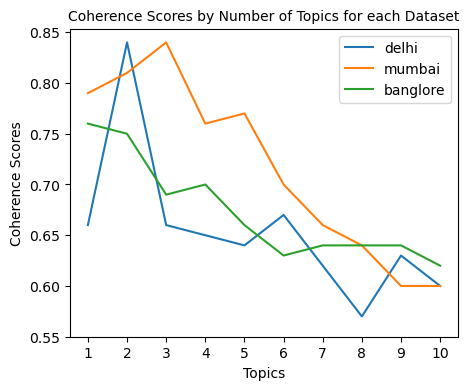

In [5]:
plt.figure(figsize = (5, 4));
sns.lineplot(top_coh["del"], markers = True, label = "delhi");
sns.lineplot(top_coh["mum"], markers = True, label = "mumbai");
sns.lineplot(top_coh["ban"], markers = True, label = "banglore");
plt.gca().set_xticks(range(1, 11));
plt.gca().set_xlabel("Topics");
plt.gca().set_yticks(np.arange(.55, .9, 0.05));
plt.gca().set_ylabel("Coherence Scores");
plt.legend();
plt.title("Coherence Scores by Number of Topics for each Dataset", fontsize = 10);
os.chdir('/home/prabhur/reddit_project/')
plt.savefig("TopvsCoherencev1.jpg")

In [6]:
del_two_topics = topic_coherence(del_df["processed_text"], 2, return_coh = False)
mum_two_topics = topic_coherence(mum_df["processed_text"], 2, return_coh = False)
ban_two_topics = topic_coherence(ban_df["processed_text"], 2, return_coh = False)

In [16]:
del_two_topics[1][-1]

0.7542659936208005

In [41]:
def plot_topic_word_heatmap(topics, subreddit, num_topics = 2, num_words = 20):
    fig = plt.figure(figsize = (20,5))    
    score = []
    word = []
    topic = []
    coh = 0
    for i in range(num_topics):     #for each topic
        coh += topics[i][-1] 
        for j in range(num_words):
            score.append(round(topics[i][0][j][0], 4))
            word.append(topics[i][0][j][1])
            topic.append(f"""Topic {str(i+1)}""")

    _ = pd.DataFrame({"Topics": topic, "word" : word, "score" : score})
    _.sort_values(["Topics", "score"], ascending = [True, False], inplace = True)
    _["rank"] = list(np.arange(0, num_words).astype(str)) * 2
    _p = _.pivot_table("score", "Topics", "rank", sort =False)

    # Create an array to annotate the heatmap
    topic_labels = list(_.Topics.unique())
    annot_labels = np.asarray([f"""{word} 
{str(score)}""" for word, score in zip(_.word.values.flatten(),_.score.values.flatten())]
                        ).reshape(num_topics, num_words)
    ax = sns.heatmap(_p, cmap = "YlGnBu", fmt="", annot = annot_labels, annot_kws={"fontsize":9},
                         yticklabels = topic_labels, xticklabels = False);
    ax.set(xlabel="");
    ax.set_title(f"Topic Modeling Analysis for r/{subreddit} \n Overall Model Coherence (2 topic model): {round(coh/2, 4)}");
    plt.savefig(subreddit+"_topwords_per_topic.png")
    
    return

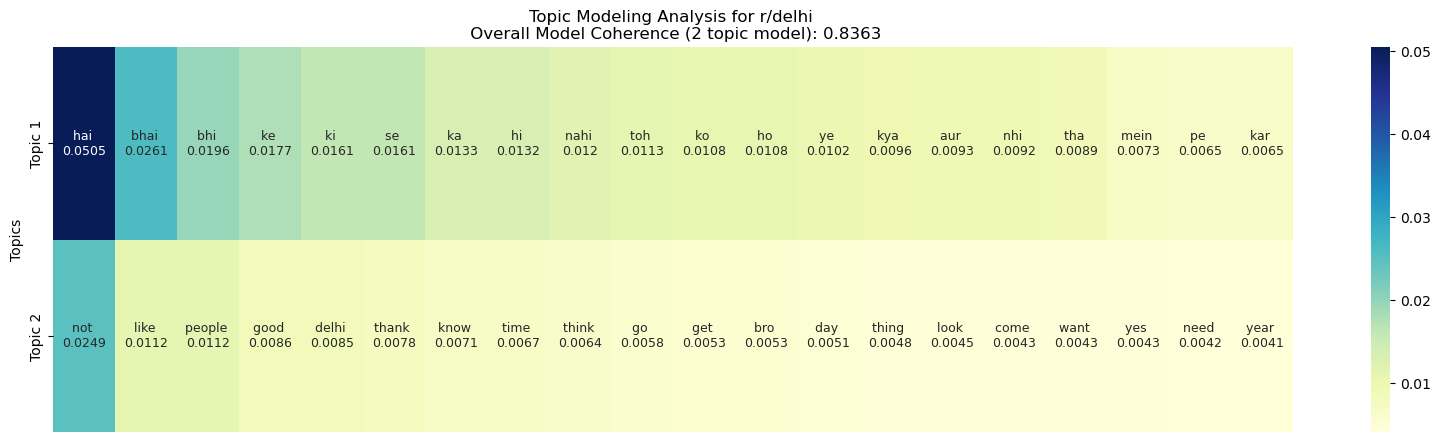

In [42]:
plot_topic_word_heatmap(del_two_topics, "delhi")

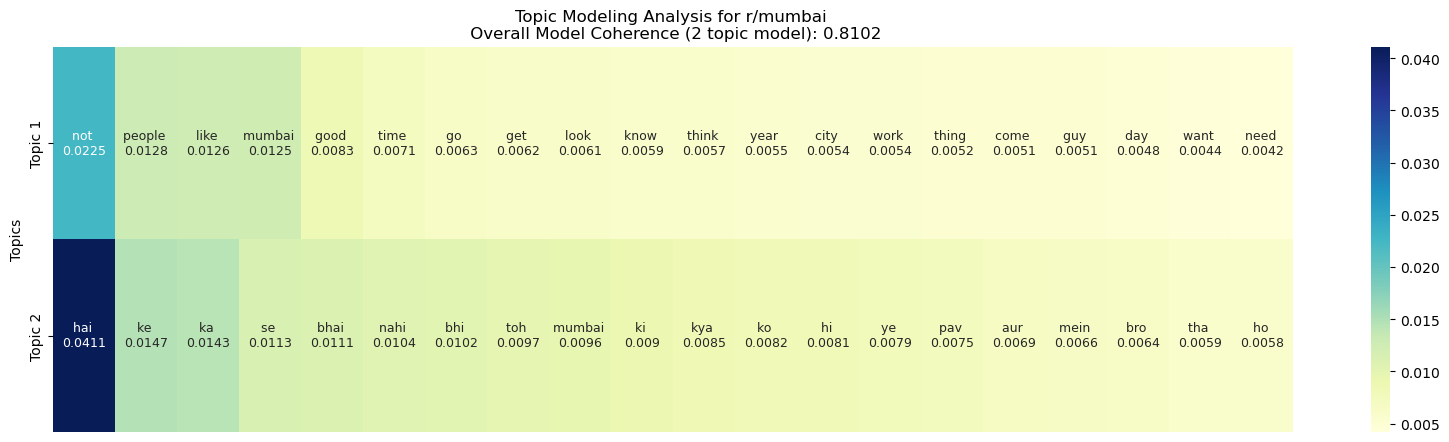

In [43]:
plot_topic_word_heatmap(mum_two_topics, "mumbai")

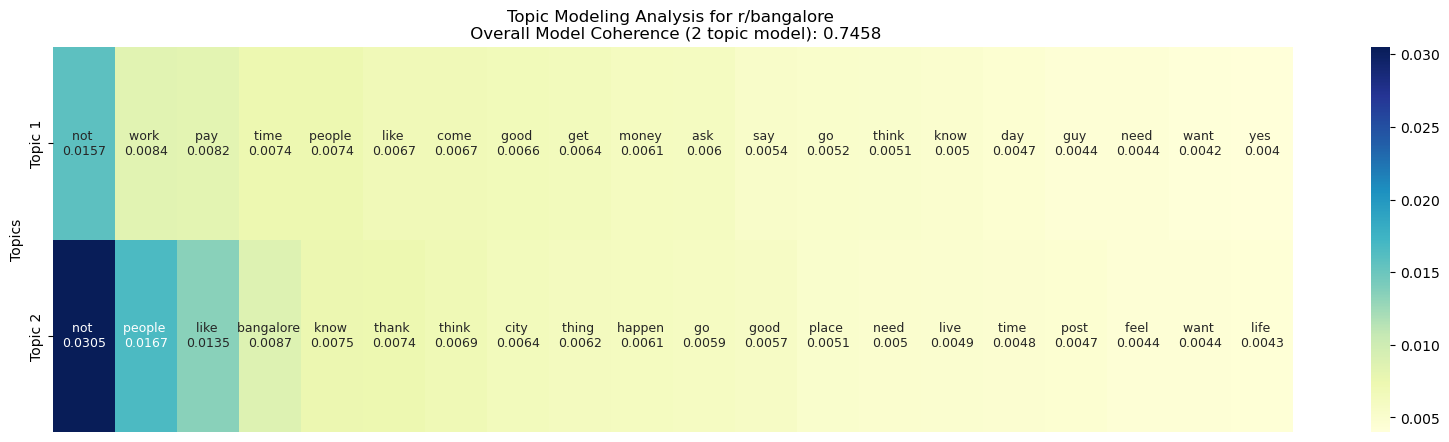

In [44]:
plot_topic_word_heatmap(ban_two_topics, "bangalore")